<a href="https://colab.research.google.com/github/Tam1979/TATA-ML/blob/master/w1_3a_sklearn_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scikit-learn Introduction

Scikit-learn is a library for machine learning in Python.  It helps us in all of the following ways:

    1. Preprocessing: Getting the data into shape for Machine Learning
    2. Dimensionality Reduction: Reducing redundancy in variables
    3. Classification: Predicting one of a finite set of classes for data.
    4. Regression: Predicting a response variable
    5. Clustering: Finding natural patterns in the data.
    6. Model Selection: Finding the best model for our data.


We will be looking at our NYCFlights13 dataset here.   


In [0]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation  import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


flights = pd.read_csv('https://s3.amazonaws.com/elephantscale-public/data/nycflights13/flights.csv.gz')
weather = pd.read_csv('https://s3.amazonaws.com/elephantscale-public/data/nycflights13/weather.csv.gz')
airports = pd.read_csv('https://s3.amazonaws.com/elephantscale-public/data/nycflights13/airports.csv.gz')

df_withweather = pd.merge(flights, weather, how='left', on=['year','month', 'day', 'hour', 'origin'])
df = pd.merge(df_withweather, airports, how='left', left_on='dest', right_on='faa')

df = df.dropna()

ModuleNotFoundError: ignored

In [0]:
# Let's examine the data

df

## Feature Vector

Let's create a feature vector.

In [0]:

pred = 'dep_delay'
features =  ['month','day','dep_time','arr_time','carrier','dest','air_time','distance', 
             'lat', 'lon', 'alt',  'dewp', 'humid', 'wind_speed', 'wind_gust', 
             'precip', 'pressure', 'visib' ]

features_v = df[features]
pred_v = df[pred]

pd.options.mode.chained_assignment = None  # default='warn'

# carrier is not a number, so transform it into an number
features_v['carrier'] = pd.factorize(features_v['carrier'])[0]

# dest is not a number, so transform it into a number
features_v['dest'] = pd.factorize(features_v['dest'])[0]



In [0]:
# Let's look at our feature vector

features_v

### Scaling the feature vector

Let's scale the feature vector.

First the standard scaler substracts by the mean and divides by std.  Let's try that ourselves and see if that looks right.

In [0]:
scaled_v = (features_v - features_v.mean()) / features_v.std()
scaled_v

### Let's apply that transformation with scikit-learn

In [0]:
# Notice how the magnitude of the dimensions is wildly different. Let's try scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_v)
scaled_features



### Reducing Dimensions

Let's use PCA to reduce dimensions down to two.

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_r = pca.fit(scaled_features).transform(scaled_features)

NameError: ignored

In [0]:
X_r

Let's examine the components of the two dimensions:

In [0]:
# The components are the two axes of the projected back into the original features space.
# We can use these to calculate the relative components of the original features in our 
# new features.

pca.components_

In [0]:
# Let's get the top components of PC1:
print("top components of PC1:")


rel_values = np.abs(pca.components_[0])/np.sum(np.abs(pca.components_[0]))
print("Feature Names: " + str([features[i] for i in np.argsort(-rel_values)[:3]]))
print("Percentages: " + str(rel_values[np.argsort(-rel_values)[:3]]))

Roughly about 75% of the variance of PC1 is explained by distance, air time, and longtitude.  These variables roughtly correspond to how long the flight is (as longitude will increase as we fly west from NYC)

In [0]:
# Let's get the top components of PC2:
print("top components of PC2:")

rel_values_pc2 = np.abs(pca.components_[1])/np.sum(np.abs(pca.components_[1]))
print("Feature Names: " + str([features[i] for i in np.argsort(-rel_values_pc2)[:6]]))
print("Percentages: " + str(rel_values_pc2[np.argsort(-rel_values_pc2)[:6]]))

Here, we have about half the variance is explained by the weather variables humidity, wind_speed, wind_guest, and dewpoint.  dep_time and arr_time together give us about 25% more.

What is the explained variance of the data?


In [0]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))



This means only about a third  of the data is explained by the two dimensions. Reducing dimensions was useful for plotting but not good as a way of capturing most of the signal.

# Plotting

Let's do a quick plot of the data. Because we have many dimensions and we want a 2-D plot, we need to reduce dimensions down to 2.  We can do this with PCA, which will reduce the dimensions to only two by combining redundant features into two principal components.


NameError: ignored

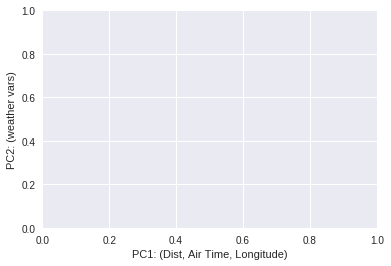

In [0]:
import matplotlib.pyplot as plt



plt.figure()
lw = 2

plt.xlabel("PC1: (Dist, Air Time, Longitude)")
plt.ylabel("PC2: (weather vars)")


plt.scatter(X_r[:,0], X_r[:,1], alpha=.8, lw=lw)
plt.title('PCA of flights dataset')



How to interpret these clusters? 

The X axis (PC1), remember, largely is based on the length of the flight.  It ranges in certain bounds, because these are domestic flights. One can only fly so far in a domestic flight.  The outlier section on the far right likely consists of Alaska, Hawaii, and other flights that are abnormally long for  being domestic flights.

The Y Axis (PC2), is largely based on weather related variables. Note the large number of small "outlier" clusters on the top. These are likely a result of abnormal weather conditions.


### Biplot

A biplot will plot both the points and the original feature vectors on the same axis, so you can visualize roughly how the original features are projected to the dimensionality 
reduced data.

In [0]:
def biplot(score,coeff,y,labels=None):
    plt.rcParams['figure.figsize'] = [15, 10]
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-0.8,0.7)
    plt.ylim(-0.6,0.5)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
# Let's do a biplot of a PCA = 2 dimensions
biplot(X_r[:,0:2],np.transpose(pca.components_[0:2, :]),pred_v,labels=features)